In [1]:
import sys
import unittest

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'axes.grid' : False})

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchsummary

%matplotlib inline

# Tensors

A tensor is an n-dimensional array consisting of elements of the same type. Every tensor has an associated shape that describes the dimensions of the tensor. For example, the shape of a 4D tensor would have four numbers that specify the size of each of the four dimensions.

- **vector:** 1D tensor with shape `[N]` where N denotes the number of elements
- **matrix:** 2D tensor with shape `[R, C]` where R and C denote the number of rows and columns, respectively
- **RGB image:** 3D tensor with shape `[C, H, W]` where C denotes the number of channels (representing color) and H and W denote the height and width, respectively

The number of tensor dimensions is known as "the rank of the tensor". Each tensor dimension is known as "an axis" of the tensor. An axis with a dimension of one is known as a singleton axis. Example usage: "In a rank four tensor of shape `[N, C, H, W]`, N denotes the dimension/size of the leading axis."

A tensor containing a batch of images would typically have the following shape: [N, C, H, W]. `N` indicates the number of images in the batch, `C` indicates the number of channels (one for grayscale images and typically three for color images), H and W are the height and width of the image respectively. ***Note that the dimensions of each image is fixed; we cannot store images of different sizes in the same tensor.***

# Convolution Arithmetic

The convolution operation takes two tensors as input and results in one tensor as output **(sometimes, we add a "bias" tensor to the result after convolving)**. The shape of the output tensor depends on the shape of the input tensor, weights/filters tensor, and convolution configuration such as padding.

The convolution layer in a neural network generally convolves the same input with many filters (ranging from few dozen to hundreds to thousands). It is equivalent to convolving the image with each filter separately and then concatenating the results into a single tensor. We also often convolve the same set of filters on a collection of input tensors (like in minibatch gradient descent).

Using the visualizations below as an aid, ***write a function that outputs the shape of the output tensor for a given input shape, filters shape, and convolution configuration.***

<table>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Padding of one, no strides</td>
    <td>Padding of two, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_odd.gif"></td>
  </tr>
  <tr>
    <td>No padding, stride of two</td>
    <td>Padding of one, stide of two</td>
    <td>Padding of one, stride of two</td>
  </tr>
</table>

**References:**
"A guide to convolution arithmetic for deep learning", https://arxiv.org/abs/1603

License for images: https://github.com/vdumoulin/conv_arithmetic/blob/master/LICENSE


In [2]:
def getConvolutionOutputShape(B, C, H, W, K, M, N, Ph=0, Pw=0, Sh=1, Sw=1):
  """
    Computes the output shape of 2D convolution for a given input and filters shape

    Input shape: [B, C, H, W]
    Filters shape: [K, C, H, W]
    
    Padding and strides are relevant for spatial dimensions only (height and width).

  Args:
    ###########################
    B: batch size
    C: number of input channels
    H: height of the input
    W: width of the input
    ########################
    K: number of filters
    ########################
    M: height of the filters
    N: width of the filters
    ######################
    Ph: vertical padding
    Pw: horizontal padding
    #######################
    Sh: vertical stride
    Sw: horizontal stride
    #######################
  """

  output_shape = np.zeros(4, dtype=int)

  # the calculation is independent and identical for each spatial axis
  def calculate_output_dim(input_size, filter_size, padding, stride):
    """returns the output dimension for a spatial axis"""
    # YOUR CODE BEGINS HERE
    output_dim=(input_size-filter_size+2*padding)//stride+1
    return output_dim    
    # YOUR CODE ENDS HERE

  # YOUR CODE BEGINS HERE
  output_shape[0] = B
  output_shape[1] = K
  output_shape[2] = calculate_output_dim(H, M, Ph, Sh)
  output_shape[3] = calculate_output_dim(W, N, Pw, Sw)
  # YOUR CODE ENDS HERE
  return list(output_shape)

In [3]:
class Test_getConvolutionOutputShape(unittest.TestCase):
  def test_simple(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 28, 32, 16, 3, 3), [1, 16, 26, 30])
    self.assertEqual(getConvolutionOutputShape(5, 3, 32, 28, 32, 3, 3), [5, 32, 30, 26])
    self.assertEqual(getConvolutionOutputShape(7, 256, 28, 28, 64, 3, 1), [7, 64, 26, 28])
    self.assertEqual(getConvolutionOutputShape(11, 256, 28, 28, 128, 1, 3), [11, 128, 28, 26])
    self.assertEqual(getConvolutionOutputShape(13, 1, 64, 64, 16, 5, 5), [13, 16, 60, 60])

  def test_padding(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 32, 28, 16, 3, 3, 1, 1), [1, 16, 32, 28])
    self.assertEqual(getConvolutionOutputShape(1, 16, 28, 32, 32, 3, 3, 3, 3), [1, 32, 32, 36])
    self.assertEqual(getConvolutionOutputShape(1, 33, 28, 28, 64, 3, 1, 1, 0), [1, 64, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 4, 7, 11, 16, 5, 5, 2, 2), [1, 16, 7, 11])

  def test_strides(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 28, 28, 16, 3, 3, 0, 0, 2, 2), [1, 16, 13, 13])
    self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 32, 3, 3, 1, 1, 2, 2), [1, 32, 14, 14])
    self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 64, 3, 1, 2, 2, 2, 2), [1, 64, 15, 16])
    self.assertEqual(getConvolutionOutputShape(1, 128, 28, 28, 128, 1, 3, 0, 1, 4, 4), [1, 128, 7, 7])

  def test_misc(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 13, 13, 16, 1, 1), [1, 16, 13, 13])

unittest.main(Test_getConvolutionOutputShape(), argv=[''], verbosity=2, exit=False)

test_misc (__main__.Test_getConvolutionOutputShape) ... ok
test_padding (__main__.Test_getConvolutionOutputShape) ... ok
test_simple (__main__.Test_getConvolutionOutputShape) ... ok
test_strides (__main__.Test_getConvolutionOutputShape) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.017s

OK


# Convolution

Implement the `convolve2d` that convolves a filter (unit strides and zero padding) on a greyscale image. The animated visual aid shows this configuration.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"/>

In [4]:
def convolve2d(image, kernel):
  """
    Convolve a 2D image with a kernel (2D filter)

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)

  H, W = image.shape
  M, N = kernel.shape

  
  # YOUR CODE BEGINS HERE
  result_H = H+1-M
  result_W = W+1-N
  # YOUR CODE ENDS HERE

  result = np.zeros((result_H, result_W), dtype=np.float32)
  # YOUR CODE BEGINS HERE
  # Implement convolution using two loops
  for i in range(result_H):
    for j in range(result_W):
      result[i][j]=np.sum(np.multiply(image[i:i+M, j:j+M], kernel))

  
  # YOUR CODE ENDS HERE

  return result

In [5]:
def convolve2d_ref(image, kernel):
  from scipy import signal
  return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d(unittest.TestCase):
  def test(self):
    image1 = np.random.random((16, 16))
    kernel1 = np.ones((3, 3), dtype=np.float32)
    kernel1 /= np.sum(kernel1)
    self.assertTrue(np.allclose(convolve2d(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

    image2 = np.random.random((32, 32))
    kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
    kernel2 /= np.sum(kernel2)
    self.assertTrue(np.allclose(convolve2d(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

    image3 = np.random.random((256, 256))
    kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    kernel3 /= np.sum(np.abs(kernel3))
    self.assertTrue(np.allclose(convolve2d(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.629s

OK


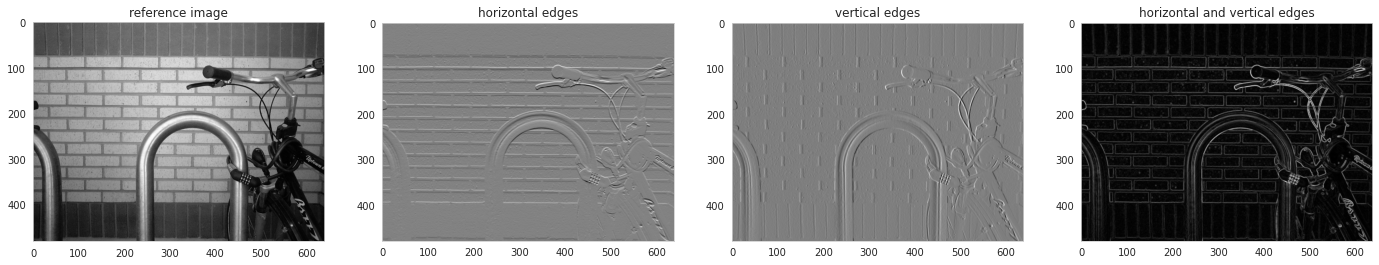

In [6]:
import skimage.io as sio
image = sio.imread("https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg", as_gray=True)

# https://en.wikipedia.org/wiki/Sobel_operator
sobel_filter_horizontal = np.asarray([
  [ 1,  2,  1],
  [ 0,  0,  0],
  [-1, -2, -1]
], dtype=np.float32)

sobel_filter_vertical = sobel_filter_horizontal.T

# convolve image with Sobel operators using your implementation
image_sobel_h = convolve2d(image, sobel_filter_horizontal)
image_sobel_v = convolve2d(image, sobel_filter_vertical)
image_sobel_hv =  np.sqrt(image_sobel_h**2 + image_sobel_v**2)

# convolve image with Sobel operators using reference implementation
image_sobel_h_ref = convolve2d_ref(image, sobel_filter_horizontal)
image_sobel_v_ref = convolve2d_ref(image, sobel_filter_vertical)

fig, axes = plt.subplots(1, 4, figsize=(24,6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("reference image")
axes[1].imshow(image_sobel_h, cmap='gray')
axes[1].set_title("horizontal edges")
axes[2].imshow(image_sobel_v, cmap='gray')
axes[2].set_title("vertical edges")
axes[3].imshow(image_sobel_hv, cmap='gray')
axes[3].set_title("horizontal and vertical edges")
plt.show()

# Convolution as Matrix Multiplication

Convolution is a linear operation. We can represent convolution as a matrix multiplication of a transformed filter matrix with the input matrix.

Consider an input $\mathbf{X}$ and a kernel $\mathbf{W}$.

$$$$

$$\mathbf{X} = \begin{pmatrix}x_{00} & x_{01} & x_{02} \\ x_{10} & x_{11} & x_{12} \\ x_{20} & x_{21} & x_{22} \end{pmatrix}\$$

$$\mathbf{W} = \begin{pmatrix}w_{00} & w_{01} \\ w_{10} & w_{11} \end{pmatrix}$$

$$$$

Let the result of the convolution of $\mathbf{X}$ with $\mathbf{W}$ be denoted by $\mathbf{Y}$.

$$\mathbf{Y} = \mathbf{X} * \mathbf{Y}$$

$$\mathbf{Y} = \begin{pmatrix}
w_{00}*x_{00} + w_{01}*x_{01} + w_{10}*x_{10} + w_{11}*x_{11} &
w_{00}*x_{01} + w_{01}*x_{02} + w_{10}*x_{11} + w_{11}*x_{12} \\
w_{00}*x_{10} + w_{01}*x_{11} + w_{10}*x_{20} + w_{11}*x_{21} &
w_{00}*x_{11} + w_{01}*x_{12} + w_{10}*x_{21} + w_{11}*x_{22}
 \end{pmatrix}$$

$$$$

We can express the result as matrix multiplication of a transformed weight matrix with the input matrix.

$$\mathbf{Y} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

#####################################################################
# 1. Assuming the input and kernel shape to be `[H, W]` and `[M, N]` respectively, what is the shape of the transformed kernel matrix?
# 2. Complete the `transform_kernel` function. It must construct the transformed kernel matrix for a given input shape and kernel matrix.
# 3. Complete the `convolve2d_matmul` function. It must convolve the input with the given kernel using the transformed matrix.
##############################################################

**References:**
- https://github.com/alisaaalehi/convolution_as_multiplication

## Answers

1. Write your answer here

In [7]:
def transform_kernel(image, kernel):
  """
    Transform kernel matrix into a new matrix such that matrix multiplication of
    the transformed matrix with the flattened input gives the result of convolution.

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)

  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE

  # Output dims is [H-M+1, W-N+1]
  # so, we want that many rows for sake of linear combination
  # height of the transformed kernel matrix
  result_H = (H-M+1)*(W-N+1)

  # width of the transformed kernel matrix
  # linear combination of all the elements in the input matrix
  result_W = H*W
  # YOUR CODE ENDS HERE

  # print("result h is ", result_H)
  # print("result w is ", result_W)

  #transformed_kernel = np.zeros((result_H * result_W, H * W), dtype=np.float32)
  transformed_kernel = np.zeros((result_H, result_W), dtype=np.float32)
  # YOUR CODE BEGINS HERE

  def find_idx_in_flattened_arr(curr_x, curr_y):
    ans=0
    ans+=curr_y
    ans+=curr_x*W
    return ans

  for i in range(H-M+1):
    for j in range(W-N+1):
      # since stride is 1,
      # x1, y1=i,j
      # x2, y2=x1, y1+N-1
      # x3, y3= x1+M-1, y1
      # x4, y4 = x1+M-1, y1+N-1
      relevant_row=i*(W-N+1)+j
      for curr_x in range(i, i+M):
        for curr_y in range(j, j+N):
          dx=curr_x-i
          dy=curr_y-j
          flattened_idx=find_idx_in_flattened_arr(curr_x, curr_y)        
          transformed_kernel[relevant_row][flattened_idx]=kernel[dx][dy]  

  
  # YOUR CODE ENDS HERE

  return transformed_kernel

def convolve2d_matmul(image, kernel):
  """
    Convolve a 2D image with a 2D kernel

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)
  
  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  result_H = H - M + 1
  result_W = W - N + 1
  # YOUR CODE ENDS HERE

  # YOUR CODE BEGINS HERE
  # 1. compute transformed kernel
  transformed_kernel=transform_kernel(image, kernel)
  ########################################################################
  # 2. flatten input (reshape the 2D input to a 1D column vector)
  flattened_image=image.flatten()
  #############################################################################
  # 3. matrix multiplication
  flattened_result=np.dot(transformed_kernel , flattened_image)
  #######################################################################
  # 4. reshape result (reshape back to 2D output from a 1D column vector)
  result=flattened_result.reshape((result_H, result_W))
  #########################################################################
  # YOUR CODE ENDS HERE

  return result

In [8]:
def convolve2d_ref(image, kernel):
  from scipy import signal
  return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d_matmul(unittest.TestCase):
  def test(self):
    image1 = np.random.random((16, 16))
    kernel1 = np.ones((3, 3), dtype=np.float32)
    kernel1 /= np.sum(kernel1)
    self.assertTrue(np.allclose(convolve2d_matmul(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

    image2 = np.random.random((32, 32))
    kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
    kernel2 /= np.sum(kernel2)
    self.assertTrue(np.allclose(convolve2d_matmul(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

    image3 = np.random.random((64, 64))
    kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    kernel3 /= np.sum(np.abs(kernel3))
    self.assertTrue(np.allclose(convolve2d_matmul(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d_matmul(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d_matmul) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.209s

OK


## Comparing convolutional layer with fully-connected layer

$$\mathbf{Y}_{fc} = \begin{pmatrix}
w_{00} & w_{01} & w_{02} & w_{03} & w_{04} & w_{05} & w_{06} & w_{07} & w_{08} & w_{09} \\
w_{10} & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & w_{16} & w_{17} & w_{18} & w_{19} \\
w_{20} & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & w_{26} & w_{27} & w_{28} & w_{29} \\
w_{30} & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & w_{36} & w_{37} & w_{38} & w_{39}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

$$\mathbf{Y}_{conv} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

## Questions

1. Express the number of learnable parameters in a fully-connected layer (without bias) in terms of `B`, `K`, `C`, `H`, `W`, `M` and `N` (as defined earlier).
2. Express the number of learnable parameters in a convolutional layer (without bias) in terms of the number of inputs `N` and outputs `M`.
4. Imagine weight matrices of a convolutional and fully-connected layer such that both operations result in the same output shape for a given input shape (the transformed toeplitz matrix must have the same shape of the fully-connected layer weights). Run the next code cell. What patterns do you observe in the weights? Is the weights matrix dense or sparse?
4. Explain what you understand by the terms "sparse connectivity" and "weight sharing" in the context of convolutional layers.
5. If a fully-connected layer can mimic convolution and is more powerful in terms of the set of functions it can represent, what is the point of using convolutions instead of them?


## Answers

Write your answers here.

#### Anmol's answers (To be tested on sample inputs)

1) KHWC (excluding bias parameters)

2) Not sure how to express just in terms of M and N. Also, does the meaning of M and N change here ????? For now, my answer seems to be : KMNC (excluding bias parameters)

3) TO DO TO DO TO DO TO DO 


In [9]:
with np.printoptions(threshold=sys.maxsize, linewidth=128):
  print("A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)")
  print(np.arange(9 * 25, dtype=np.float32).reshape(9, 25))
  print()

  print("Transformed matrix for 3x3 kernel that operates on an input with shape 5x5")
  print(transform_kernel(np.zeros((5, 5)), [[1, 2, 3], [4, 5, 6], [7, 8, 9]]))
  print()

A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)
[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.]
 [ 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.]
 [ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.]
 [ 75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.]
 [100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.]
 [125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.]
 [150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168

# Training Convolutional Neural Networks

You have to train an image classifier for CIFAR10 dataset. There are ten classes/labels in the dataset. Each image has the shape 3x32x32 (32 pixels wide and tall, with 3 color channels).The dataset consists of 50,000 training samples and 10,000 test samples.

In [10]:
# On Google Colab: Go to "Runtime" > "Change runtime type" > Select "GPU"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [11]:
# All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#  A function/transform that takes in an PIL image and returns a transformed version
train_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=False, transform=transform)
print(type(train_dataset))
print("training dataset size:", len(train_dataset))
print("test dataset size:", len(test_dataset))


Files already downloaded and verified
Files already downloaded and verified
<class 'torchvision.datasets.cifar.CIFAR10'>
training dataset size: 50000
test dataset size: 10000


In [12]:
print(len(train_dataset[0]))
print(type(train_dataset[0]))

2
<class 'tuple'>


In [13]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [14]:
# YOUR CODE BEGINS HERE
# portion a part of the training dataset for validation
# use 90% of the training dataset for training and the rest for validation
# use `torch.utils.data.random_split`
train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

# YOUR CODE ENDS HERE

print("training dataset size:", train_size)
print("validation dataset size:", valid_size)

training dataset size: 45000
validation dataset size: 5000


In [15]:
'''Combines a dataset and a sampler, and provides an iterable over the given dataset. The DataLoader supports both map-style and 
iterable-style datasets with single- or multi-process loading, customizing loading order
and optional automatic batching (collation) and memory pinning.'''

# We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. 
# Here we define a batch size of 16, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset)
test_dataloader = torch.utils.data.DataLoader(test_dataset)

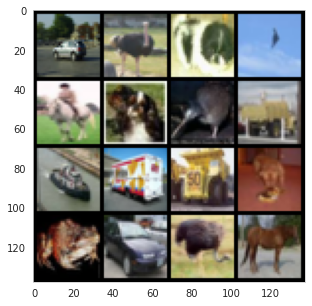

In [16]:
# remember that our batch size was 16
images, _ = next(iter(train_dataloader))
images = images * 0.5 + 0.5 # undo normalization for displaying images
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1, 2, 0))

In [17]:
# We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

'''
To define a neural network in PyTorch, we create a class that inherits from nn.Module. 
We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function.
 To accelerate operations in the neural network, we move it to the GPU if available.
'''
class SMAIConvNet(nn.Module):
  def __init__(self):
    super(SMAIConvNet, self).__init__()
    ################################################################
    ## https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    ## stride is ONE by default, same means SAME PADDING ON BOTH SIDEs
    ## Also, same means MAKE input size same as output size and apply apt padding on both sides
    ## "SAME": output size is the same as input size. This requires the filter window to slip outside input map, hence the need to pad.
    # By default, use_BIAS is TRUE
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')

    ## N x 8 x 32 x 32
    ## Applies a 2D max pooling over an input signal composed of several input planes.
    ## In the simplest case, the output value of the layer with input size (N, C, H, W)(N,C,H,W), output (N, C, H_{out}, W_{out})(N,C,H_out,W_out ) 
    ## default stride = kernel size
    ## default padding = 0

    ## Total cells= 32 x 32 . So, final output seems to be 16 x 16 to me
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)


    #########################################################
    # YOUR CODE BEGINS HERE
    # Conv2D with 32 filters, 3x3 kernel and 'same' padding
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding='same')

    ## Output of conv2 = input of maxpool2: N x 32 x 16 x 16
    # MaxPool2D with with window size 2x2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    ## Total cells= 16 x 16 . So, final output seems to be 8 x 8 to me

    ##############################################

    ## Input to me seems to be : N x 32 x 8 x 8
    # Conv2D with 32 filters, 3x3 kernel and 'same' padding
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
    
    ## Output of conv3 seems to be N x 32 x 8 x 8

    # Linear layer with 128 output features
    # Dropout with drop probability of 0.2
    self.fc1 =  nn.Linear(in_features=32*8*8, out_features=128)

    ### During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.
    self.dropout1 =  nn.Dropout(p=0.2)

    # Linear layer with 10 output features
    self.fc2 =  nn.Linear(in_features=128, out_features=10)
    # YOUR CODE ENDS HERE

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = F.relu(x)

    # YOUR CODE BEGINS HERE
    # conv2 > maxpool2 > ReLU
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = F.relu(x)

    # conv3 > ReLU
    x = self.conv3(x)
    x = F.relu(x)

    # fc1 > dropout1 > ReLU
    x = x.view(-1, 32 * 8 * 8)
    x = self.fc1(x)
    x = self.dropout1(x)
    x = F.relu(x)
    

    # fc2
    x=self.fc2(x)

    # YOUR CODE ENDS HERE
    return x

In [18]:
torchsummary.summary(SMAIConvNet().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           2,336
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           9,248
            Linear-6                  [-1, 128]         262,272
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 275,370
Trainable params: 275,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.17
Params size (MB): 1.05
Estimated Total Size (MB): 1.24
----------------------------------------------------------------


In [19]:
print(len(train_dataloader))
print(45000/16)

2813
2812.5


In [20]:
def train(model, device, train_dataloader, optimizer, criterion):
  """trains for one epoch"""
  
  model.train()
  accumulated_loss = 0.0
  for data in train_dataloader:
    (inputs, labels) = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    ## data WAS a list of [inputs, labels]
    # YOUR CODE BEGINS HERE
    # 1. zero existing gradients
    ## In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes.
    # zero the parameter gradients
    optimizer.zero_grad()
    
    
    ######################################
    # 2. forward the inputs
    outputs = model(inputs)
    ########################################
    # 3. compute the loss
    loss = criterion(outputs, labels)
    #######################################
    # 4. backprop the loss
    loss.backward()

    ######################################
    # 5. update the weights
    optimizer.step()

    #########################################

    # YOUR CODE ENDS HERE

    accumulated_loss += loss.item()
  return accumulated_loss / len(train_dataloader)

def test(model, device, dataloader, criterion):
  model.eval()
  accumulated_loss = 0.0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      (inputs, labels) = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # YOUR CODE BEGINS HERE
      # 1. forward the inputs
      outputs = model(inputs)
      # 2. compute the loss
      loss = criterion(outputs, labels)
      
      # YOUR CODE ENDS HERE

      accumulated_loss += loss.item()

      predictions = outputs.argmax(dim=1)
      correct += (predictions == labels).sum()

    num_samples = len(dataloader)
    avg_loss = accumulated_loss / num_samples
    return avg_loss, correct / num_samples
    

In [21]:
model = SMAIConvNet().to(device) # resets parameters

# YOUR CODE BEGINS HERE
# use CrossEntropyLoss
# use SGD with a lr=0.001 and momentum=0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# YOUR CODE ENDS HERE

best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model.state_dict(), "best_model.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

new best model
[1] training loss: 1.98
[1] validation loss: 1.60, validation accuracy: 41.26%

new best model
[2] training loss: 1.56
[2] validation loss: 1.42, validation accuracy: 50.34%

new best model
[3] training loss: 1.38
[3] validation loss: 1.27, validation accuracy: 54.68%

new best model
[4] training loss: 1.25
[4] validation loss: 1.20, validation accuracy: 57.58%

new best model
[5] training loss: 1.14
[5] validation loss: 1.09, validation accuracy: 60.72%

new best model
[6] training loss: 1.05
[6] validation loss: 1.00, validation accuracy: 64.98%

new best model
[7] training loss: 0.97
[7] validation loss: 0.95, validation accuracy: 67.00%

new best model
[8] training loss: 0.91
[8] validation loss: 0.91, validation accuracy: 67.74%

new best model
[9] training loss: 0.85
[9] validation loss: 0.85, validation accuracy: 70.02%

new best model
[10] training loss: 0.79
[10] validation loss: 0.84, validation accuracy: 71.48%

new best model
[11] training loss: 0.74
[11] val

In [22]:
model.load_state_dict(torch.load("best_model.pth"))

test_loss, test_acc = test(model, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%" % (test_loss, test_acc * 100))

test loss: 0.86, test accuracy: 70.43%


In [23]:
type(loss_history)

dict

In [24]:
loss_history.keys()

dict_keys(['train', 'validation'])

In [25]:
print(len(loss_history['train']))
print(len(loss_history['validation']))

30
30


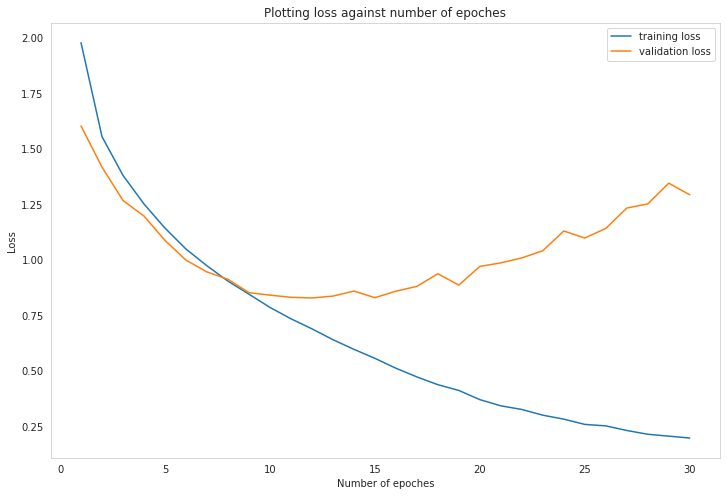

In [26]:
# plot the learning curve
# plot validation and training loss in the same plot against number of epochs (use `loss_history`)
# YOUR CODE BEGINS HERE
plt.rcParams["figure.figsize"] = (12,8)
num_epoches=len(loss_history['validation'])
x_epoches=[x+1 for x in range(num_epoches)]
plt.plot(x_epoches, loss_history['train'], label = "training loss")
plt.plot(x_epoches, loss_history['validation'], label = "validation loss")
plt.title("Plotting loss against number of epoches")
plt.xlabel("Number of epoches")
plt.ylabel("Loss")
plt.legend()
# YOUR CODE ENDS HERE

### Questions

1. What do you observe in the learning curve? Why do we require a validation set?
2. Train the network five times. Note the following quantities in a table (in the code cell below):
  - final training loss
  - best model validation loss and accuracy
  - best model test accuracy
3. Summarize your observations from the table. Does the performance differ in each round of training? What would happen if design decisions are based solely on the validation set performance from a single round of training?
4. Propose a scheme to summarize the overall performance of the model with statistics from multiple training rounds. Using the the table in the next cell, write code to summarize model performance.

### Answers

Write your answers here.




In [27]:
# fill the table with numbers from different rounds of training (ex: "training loss" : [1.21, 1.53, 0.95, 0.55, 1.14])
perf_table = {
    "training_loss" : [],
    "validation_loss" : [],
    "validation_accuracy" : [],
    "test_accuracy" : []
}

df = pd.DataFrame(perf_table)
print(df)

# YOUR CODE BEGINS HERE
# summarize the performance

# YOUR CODE ENDS HERE

Empty DataFrame
Columns: [training_loss, validation_loss, validation_accuracy, test_accuracy]
Index: []
